In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

C:\Users\Natanael\AppData\Local\Temp\ipykernel_9868\3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Lab | Natural Language Processing
### SMS: SPAM or HAM

### Let's prepare the environment

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

- Read Data for the Fraudulent Email Kaggle Challenge
- Reduce the training set to speead up development. 

In [3]:
## Read Data for the Fraudulent Email Kaggle Challenge
data = pd.read_csv("../data/kg_train.csv",encoding='latin-1')

# Reduce the training set to speed up development. 
# Modify for final system
data = data.head(1000)
print(data.shape)
data.fillna("",inplace=True)

(1000, 2)


### Let's divide the training and test set into two partitions

In [4]:
# train tset split
'''I'll do this after preprocessing the data'''
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

data_train.shape, data_test.shape

((800, 2), (200, 2))

## Data Preprocessing

In [5]:
import string
from nltk.corpus import stopwords
print(string.punctuation)
print(stopwords.words("english")[100:110])
from nltk.stem.snowball import SnowballStemmer
snowball = SnowballStemmer('english')

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each']


## Now, we have to clean the html code removing words

- First we remove inline JavaScript/CSS
- Then we remove html comments. This has to be done before removing regular tags since comments can contain '>' characters
- Next we can remove the remaining tags

In [6]:
import re
from bs4 import BeautifulSoup

def clean_text(text):
    # Step 1: Remove inline JavaScript/CSS
    text = re.sub(r'<(script|style).*?>.*?</\1>', '', text, flags=re.DOTALL)
    
    # Step 2: Remove HTML comments
    text = re.sub(r'<!--.*?-->', '', text, flags=re.DOTALL)
    
    # Step 3: Remove remaining HTML tags using BeautifulSoup
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text(separator=' ')  # Extract text and separate with spaces
    
    # Step 4: General regex to remove any encodings like =XX (two hexadecimal digits)
    text = re.sub(r'=[0-9A-Fa-f]{2}', ' ', text)

    # Step 5: Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [7]:
data_train['text'] = data_train['text'].apply(clean_text)
data_test['text'] = data_test['text'].apply(clean_text)

C:\Users\Natanael\AppData\Local\Temp\ipykernel_9868\3387752599.py:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
C:\Users\Natanael\AppData\Local\Temp\ipykernel_9868\3387752599.py:12: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


- Remove all the special characters
    
- Remove numbers
    
- Remove all single characters
 
- Remove single characters from the start

- Substitute multiple spaces with single space

- Remove prefixed 'b'

- Convert to Lowercase

In [ ]:
def more_cleaning(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # Remove standalone single characters
    text = re.sub(r'\b\w\b', '', text)

    # Remove prefixed 'b'
    text = text.lstrip('b')

    # Remove any extra spaces again, just to be sure
    text = re.sub(r'\s+', ' ', text)

    # Convert to lowercase
    text = text.lower()

# clean more
data_train['text'] = data_train['text'].apply(more_cleaning)
data_test['text'] = data_test['text'].apply(more_cleaning)

data_train.head()

,text,label
29,regards mr nelson smith kindly reply me on my...,1
535,have not been able to reach oscar this am we ...,0
695,huma abedin checking with pat on the will wor...,0
557,can have it announced here on monday can today,0
836,bank of africaagence san pedro bp san pedro co...,1


## Now let's work on removing stopwords
Remove the stopwords.

In [ ]:
# stopwords
stop = stopwords.words('english')

data_train['text'] = data_train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
data_test['text'] = data_test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

data_train.head()

,text,label
29,regards mr nelson smith kindly reply private e...,1
535,able reach oscar supposed send pdb receive,0
695,huma abedin checking pat work jack jake rest a...,0
557,announced monday today,0
836,bank africaagence san pedro bp san pedro cote ...,1


## Tame Your Text with Lemmatization
Break sentences into words, then use lemmatization to reduce them to their base form (e.g., "running" becomes "run"). See how this creates cleaner data for analysis!

In [11]:
# Lemmatization
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

data_train['text'] = data_train['text'].apply(lambda x: ' '.join([wordnet_lemmatizer.lemmatize(word) for word in x.split()]))
data_test['text'] = data_test['text'].apply(lambda x: ' '.join([wordnet_lemmatizer.lemmatize(word) for word in x.split()]))
data_train.head()

,text,label
29,regard mr nelson smith kindly reply private em...,1
535,able reach oscar supposed send pdb receive,0
695,huma abedin checking pat work jack jake rest a...,0
557,announced monday today,0
836,bank africaagence san pedro bp san pedro cote ...,1


## Bag Of Words
Let's get the 10 top words in ham and spam messages (**EXPLORATORY DATA ANALYSIS**)

In [15]:
# bag of words. Let's get the 10 top words in ham and spam messages
from collections import Counter

# Split the dataset into ham and spam messages
ham = data_train[data_train['label'] == 0]
spam = data_train[data_train['label'] == 1]

# Initialize counters
tf_ham = Counter()
tf_spam = Counter()

# Count word frequency in ham messages
for message in ham['text']:
    for word in message.split():
        tf_ham[word] += 1

# Count word frequency in spam messages
for message in spam['text']:
    for word in message.split():
        tf_spam[word] += 1

# Top 10 words in ham messages
print('Top 10 words in ham messages:')
print(tf_ham.most_common(10))

# Top 10 words in spam messages
print('\nTop 10 words in spam messages:')
print(tf_spam.most_common(10))

Top 10 words in ham messages:
[('state', 117), ('pm', 97), ('would', 94), ('president', 89), ('mr', 89), ('time', 81), ('percent', 80), ('obama', 77), ('call', 74), ('secretary', 74)]

Top 10 words in spam messages:
[('money', 848), ('account', 741), ('bank', 643), ('fund', 626), ('u', 600), ('transaction', 471), ('mr', 446), ('business', 424), ('country', 423), ('million', 370)]


## Extra features

In [16]:
# use correct variables in this box
data_train = data_train.rename(columns={'text':'preprocessed_text'})
data_val = data_test.rename(columns={'text':'preprocessed_text'})

# We add to the original dataframe two additional indicators (money symbols and suspicious words).
money_simbol_list = "|".join(["euro","dollar","pound","€","$"])
suspicious_words = "|".join(["free","cheap","sex","money","account","bank","fund","transfer","transaction","win","deposit","password"])

# Add the indicators
data_train['money_mark'] = data_train['preprocessed_text'].str.contains(money_simbol_list)*1
data_train['suspicious_words'] = data_train['preprocessed_text'].str.contains(suspicious_words)*1
data_train['text_len'] = data_train['preprocessed_text'].apply(lambda x: len(x)) 

data_val['money_mark'] = data_val['preprocessed_text'].str.contains(money_simbol_list)*1
data_val['suspicious_words'] = data_val['preprocessed_text'].str.contains(suspicious_words)*1
data_val['text_len'] = data_val['preprocessed_text'].apply(lambda x: len(x)) 

data_train.head()

,preprocessed_text,label,money_mark,suspicious_words,text_len
29,regard mr nelson smith kindly reply private em...,1,1,0,79
535,able reach oscar supposed send pdb receive,0,1,0,42
695,huma abedin checking pat work jack jake rest a...,0,1,0,76
557,announced monday today,0,1,0,22
836,bank africaagence san pedro bp san pedro cote ...,1,1,1,1050


## How would work the Bag of Words with Count Vectorizer concept?

In [21]:
# Bag of words with count vectorizer concept
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the vectorizer
vectorizer = CountVectorizer()

# Fit and transform the training data
X_train = vectorizer.fit_transform(data_train['preprocessed_text'])

# Transform the validation data
X_val = vectorizer.transform(data_val['preprocessed_text'])

# Check the shape of the resulting matrices
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}\n")

# Check the vocabulary
print(list(vectorizer.vocabulary_.items())[:5])
print(len(vectorizer.vocabulary_))
print()

# Check the first 10 words in the vocabulary
print(list(vectorizer.vocabulary_.keys())[:10])
print()

# Display the first few feature names (columns of the sparse matrix)
print(vectorizer.get_feature_names_out()[:10])

X_train shape: (800, 27709)
X_val shape: (200, 27709)

[('regard', 19125), ('mr', 14727), ('nelson', 15263), ('smith', 20912), ('kindly', 12401)]
27709

['regard', 'mr', 'nelson', 'smith', 'kindly', 'reply', 'private', 'email', 'address', 'nelsonsmith']

['aa' 'aaa' 'aabeiawaeaambiqaceqedeqh' 'aac' 'aacw' 'aae'
 'aaecaxeebsexbhjbuqdhcrmimoeifekrobhbcsmzuvavynlrchyknoel' 'aaegmdbsch'
 'aaeh' 'aaevvsghq']


## TD-IDF

- Load the vectorizer

- Vectorize all dataset

- print the shape of the vetorized dataset

In [22]:
# td-idf
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train = vectorizer.fit_transform(data_train['preprocessed_text'])

# Transform the validation data
X_val = vectorizer.transform(data_val['preprocessed_text'])

# Check the shape of the resulting matrices
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}\n")

# Check the vocabulary
print(list(vectorizer.vocabulary_.items())[:5])
print(len(vectorizer.vocabulary_))
print()

# Check the first 10 words in the vocabulary
print(list(vectorizer.vocabulary_.keys())[:10])
print()



X_train shape: (800, 27709)
X_val shape: (200, 27709)

[('regard', 19125), ('mr', 14727), ('nelson', 15263), ('smith', 20912), ('kindly', 12401)]
27709

['regard', 'mr', 'nelson', 'smith', 'kindly', 'reply', 'private', 'email', 'address', 'nelsonsmith']



## And the Train a Classifier?

Accuracy: 0.925

              precision    recall  f1-score   support

           0       1.00      0.88      0.94       125
           1       0.83      1.00      0.91        75

    accuracy                           0.93       200
   macro avg       0.92      0.94      0.92       200
weighted avg       0.94      0.93      0.93       200



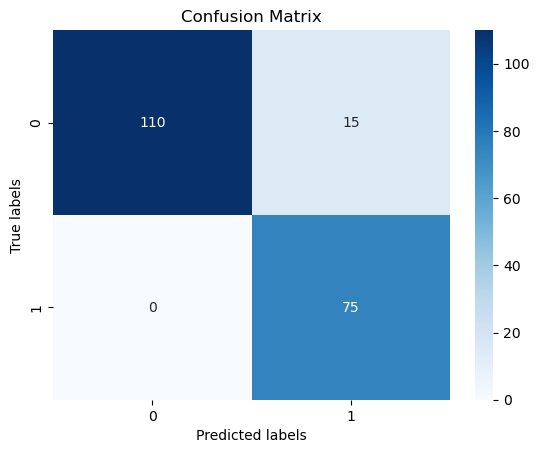

In [23]:
# train a classifier (naives bayes)
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the classifier
clf = MultinomialNB()

# Fit the model
clf.fit(X_train, data_train['label'])

# Predict the validation set
y_pred = clf.predict(X_val)

# Check the accuracy
print(f"Accuracy: {accuracy_score(data_val['label'], y_pred)}\n")

# Check the classification report
print(classification_report(data_val['label'], y_pred))

# Check the confusion matrix
cm = confusion_matrix(data_val['label'], y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


### Extra Task - Implement a SPAM/HAM classifier

https://www.kaggle.com/t/b384e34013d54d238490103bc3c360ce

The classifier can not be changed!!! It must be the MultinimialNB with default parameters!

Your task is to find the **best feature representation**.

You can work with teams of two persons (recommended).

In [ ]:
# Your code